In [2]:

# Lung Cancer Detection in Machine Learning
# Model Selection: 
# - Decision Tree
# - SVM
# - Random Forest (bagging)
# - Logistic Regression
# - Gradient Boosting

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression


In [4]:
# Load the dataset
train = pd.read_csv('data_lung_cancer.csv')

# Encode categorical feature
train['GENDER'] = train['GENDER'].map({'M':0, 'F':1})
train['LUNG_CANCER'] = train['LUNG_CANCER'].map({'NO':0, 'YES':1})

# Feature Engineering
train['CHRONIC_FATIGUE'] = train['CHRONIC DISEASE'] + train['FATIGUE']
train['COUGH_BREATH'] = train['COUGHING'] + train['SHORTNESS OF BREATH']

train = train.drop(['GENDER', 'ALLERGY', 'PEER_PRESSURE'], axis=1)

# Preview
train.head()

,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,CHRONIC DISEASE,FATIGUE,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER,CHRONIC_FATIGUE,COUGH_BREATH
0,69,1,2,2,1,2,2,2,2,2,2,2,1,3,4
1,74,2,1,1,2,2,1,1,1,2,2,2,1,4,3
2,59,1,1,1,1,2,2,1,2,2,1,2,0,3,4
3,63,2,2,2,1,1,1,2,1,1,2,2,0,2,2
4,63,1,2,1,1,1,2,1,2,2,1,1,0,2,4


In [5]:
# Split dataset - Seprate features and target
X = train.drop(['LUNG_CANCER'], axis=1)
y = train['LUNG_CANCER']

# Fill missing values with mean
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

original_columns = train.drop(['LUNG_CANCER'], axis=1).columns
X = pd.DataFrame(X, columns=original_columns)

# Split into train/test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

In [6]:
# Train & Evaluate ML Models

✅ Best Parameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
✅ Cross-Validation Accuracy (Best Model): 64.60%
✅ Test Accuracy: 57.03%

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.55      0.47        91
           1       0.71      0.58      0.64       172

    accuracy                           0.57       263
   macro avg       0.56      0.57      0.55       263
weighted avg       0.61      0.57      0.58       263



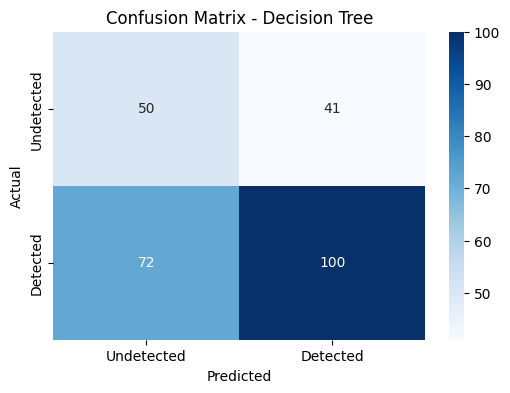

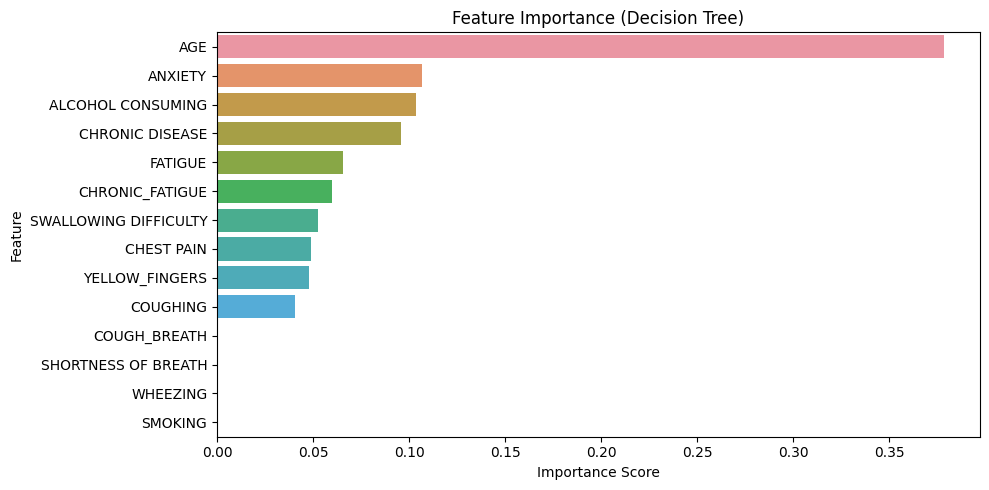

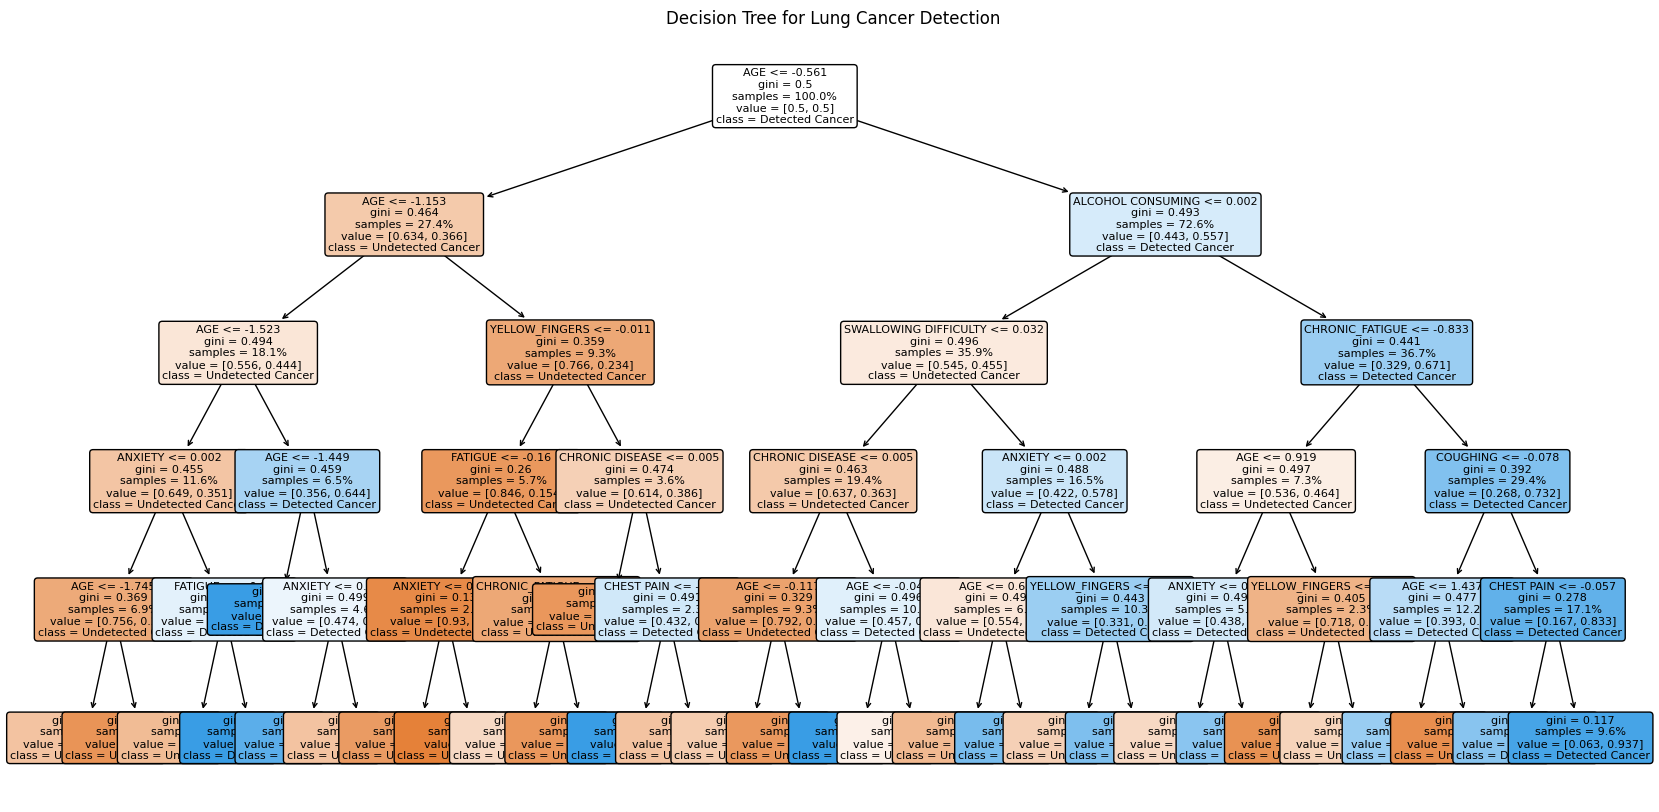

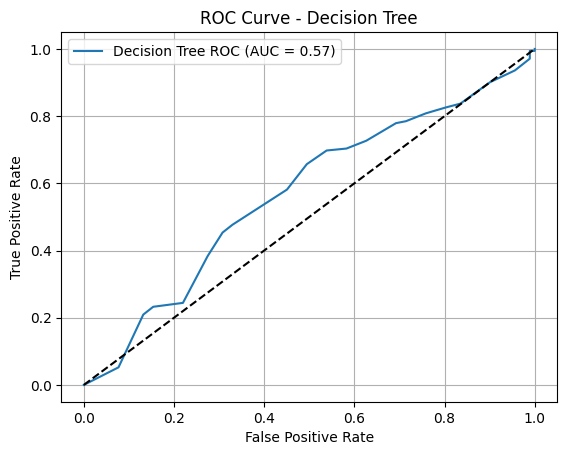

In [7]:
# Decision Tree

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'max_depth': [3, 5, 6, 8],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(
        class_weight='balanced', 
        random_state=42
    ),
    param_grid,
    cv=5,
    scoring='accuracy'
)

dt_grid.fit(X_train, y_train)
dt_model = dt_grid.best_estimator_
print(f"✅ Best Parameters: {dt_grid.best_params_}")
print(f"✅ Cross-Validation Accuracy (Best Model): {dt_grid.best_score_ * 100:.2f}%")

# Test prediction
y_pred = dt_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("✅ Test Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Undetected', 'Detected'],
            yticklabels=['Undetected', 'Detected'])
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature importance
importances = dt_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
sns.barplot(x=importances[sorted_idx], y=feature_names[sorted_idx])
plt.title("Feature Importance (Decision Tree)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Tree Visualization
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    filled=True,
    feature_names=feature_names,
    class_names=['Undetected Cancer', 'Detected Cancer'],
    proportion=True,
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree for Lung Cancer Detection")
plt.show()

# ROC Curve
dt_prob = dt_model.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_prob)
auc_dt = auc(fpr_dt, tpr_dt)

plt.figure()
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree ROC (AUC = {auc_dt:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend()
plt.grid(True)
plt.show()

Accuracy (Unscaled): 64.64%
SVM Accuracy with RBF Kernel: 60.08%
SVM Accuracy with Linear Kernel: 61.98%

Classification Report (RBF Kernel):
              precision    recall  f1-score   support

           0       0.44      0.58      0.50        91
           1       0.73      0.61      0.67       172

    accuracy                           0.60       263
   macro avg       0.59      0.60      0.58       263
weighted avg       0.63      0.60      0.61       263


Classification Report (Linear Kernel):
              precision    recall  f1-score   support

           0       0.46      0.58      0.51        91
           1       0.74      0.64      0.69       172

    accuracy                           0.62       263
   macro avg       0.60      0.61      0.60       263
weighted avg       0.65      0.62      0.63       263

Cross-Validation Accuracy (RBF): 59.86%
Cross-Validation Accuracy (Linear): 59.55%


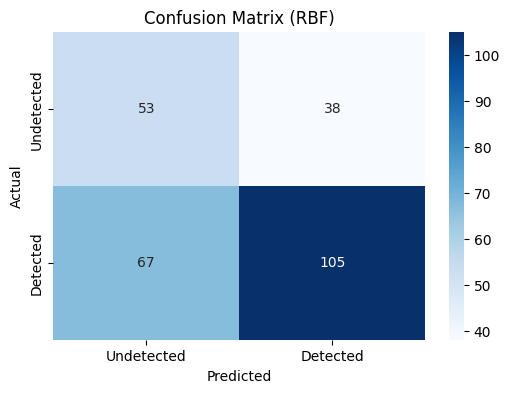

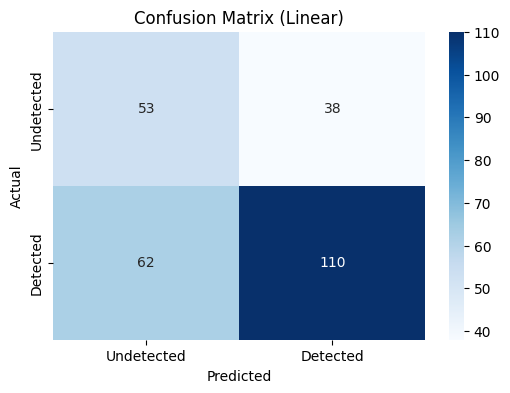

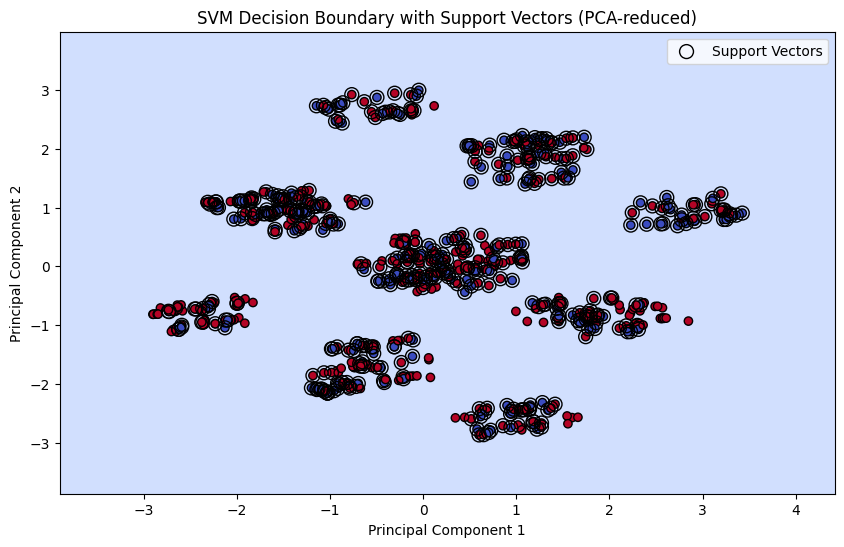

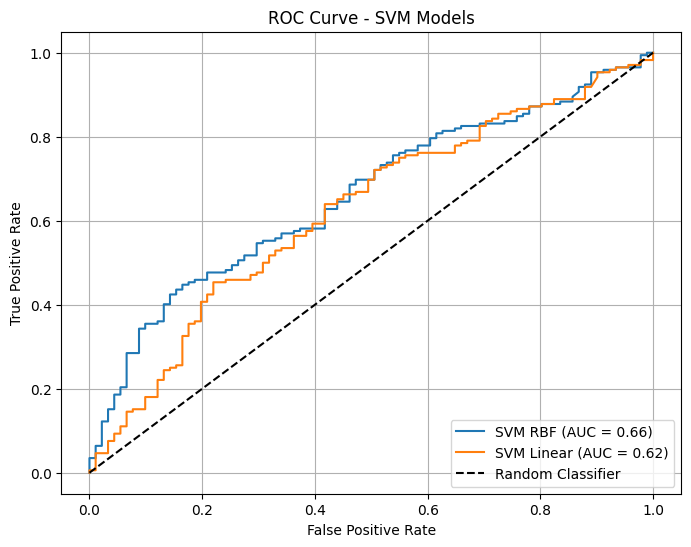

In [8]:
# SVM
# standardized features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM on unscaled data 
svm_unscaled = SVC(kernel='rbf', C=1.0)
svm_unscaled.fit(X_train, y_train)
y_pred_unscaled = svm_unscaled.predict(X_test)
print(f"Accuracy (Unscaled): {accuracy_score(y_test, y_pred_unscaled):.2%}")

#train SVM with rbf kernel
svm = SVC(
    kernel='rbf', 
    C=1.0, 
    gamma='scale', 
    random_state=42, 
    class_weight='balanced',
    probability=True
)
svm.fit(X_train_scaled, y_train)

#train SVM with linear kernel
svm_linear = SVC(
    kernel='linear', 
    C=1.0,
    class_weight='balanced',
    probability=True
)
svm_linear.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred1 = svm.predict(X_test_scaled)
y_pred2 = svm_linear.predict(X_test_scaled)
accuracy1 = accuracy_score(y_test, y_pred1)
accuracy2 = accuracy_score(y_test, y_pred2)
print(f"SVM Accuracy with RBF Kernel: {accuracy1:.2%}")
print(f"SVM Accuracy with Linear Kernel: {accuracy2:.2%}")

print("\nClassification Report (RBF Kernel):")
print(classification_report(y_test, y_pred1))

print("\nClassification Report (Linear Kernel):")
print(classification_report(y_test, y_pred2))

scores_rbf = cross_val_score(svm, X_train_scaled, y_train, cv=5)
print("Cross-Validation Accuracy (RBF): {:.2f}%".format(scores_rbf.mean() * 100))

scores_linear = cross_val_score(svm_linear, X_train_scaled, y_train, cv=5)
print("Cross-Validation Accuracy (Linear): {:.2f}%".format(scores_linear.mean() * 100))

#confusion matrix of both SVM
cm1 = confusion_matrix(y_test, y_pred1)
plt.figure(figsize=(6, 4))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Undetected', 'Detected'],
            yticklabels=['Undetected', 'Detected']
)
plt.title('Confusion Matrix (RBF)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

cm2 = confusion_matrix(y_test, y_pred2)
plt.figure(figsize=(6, 4))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Undetected', 'Detected'],
            yticklabels=['Undetected', 'Detected']
)
plt.title('Confusion Matrix (Linear)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Decision boundary visualization (using PCA for 2D projection)
def plot_decision_boundary():
    # Reduce to 2 dimensions using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_train_scaled)

    # Create grid for plotting
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Train SVM on PCA-transformed data
    #svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
    svm_pca = SVC(kernel='linear', C=1.0)
    svm_pca.fit(X_pca, y_train)

    # Predict on grid
    Z = svm_pca.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='coolwarm', edgecolors='k')
    plt.scatter(svm_pca.support_vectors_[:, 0],
                svm_pca.support_vectors_[:, 1],
                s=100, facecolors='none', edgecolors='k', label='Support Vectors')
    plt.title('SVM Decision Boundary with Support Vectors (PCA-reduced)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

plot_decision_boundary()

# Get predicted probabilities for class 1 (detected)
svm_prob = svm.predict_proba(X_test_scaled)[:, 1]
svm_linear_prob = svm_linear.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC Curve and AUC
fpr_rbf, tpr_rbf, _ = roc_curve(y_test, svm_prob)
auc_rbf = auc(fpr_rbf, tpr_rbf)

fpr_linear, tpr_linear, _ = roc_curve(y_test, svm_linear_prob)
auc_linear = auc(fpr_linear, tpr_linear)

# Plot both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rbf, tpr_rbf, label=f'SVM RBF (AUC = {auc_rbf:.2f})')
plt.plot(fpr_linear, tpr_linear, label=f'SVM Linear (AUC = {auc_linear:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

✅ Random Forest Accuracy: 64.26%

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.48      0.34      0.40        91
           1       0.70      0.80      0.75       172

    accuracy                           0.64       263
   macro avg       0.59      0.57      0.57       263
weighted avg       0.62      0.64      0.63       263

Cross-Validation Accuracy (RF): 65.25%


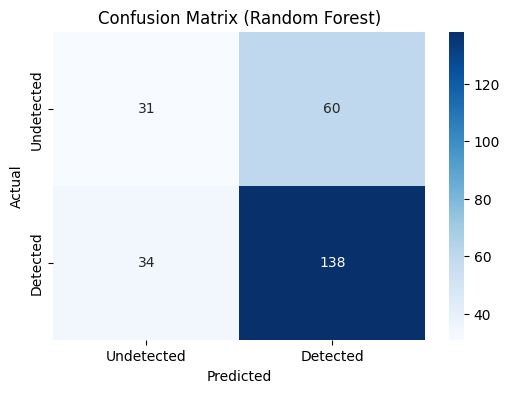

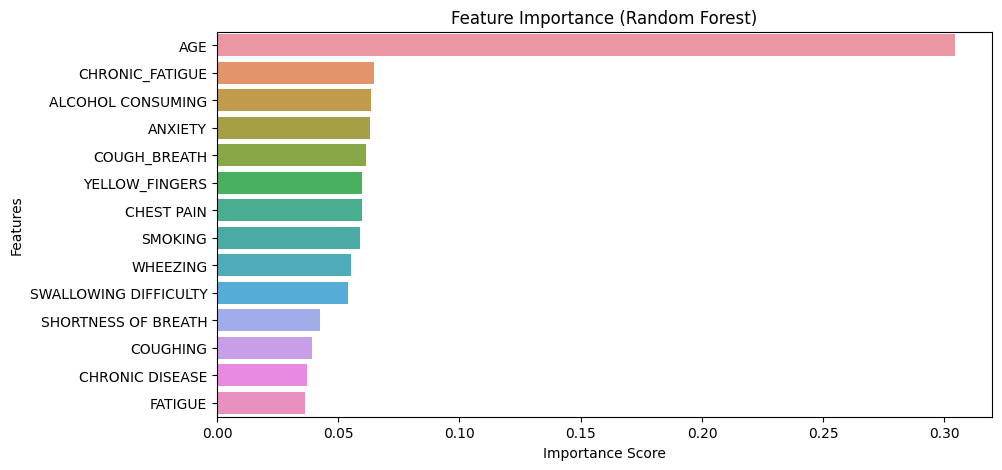

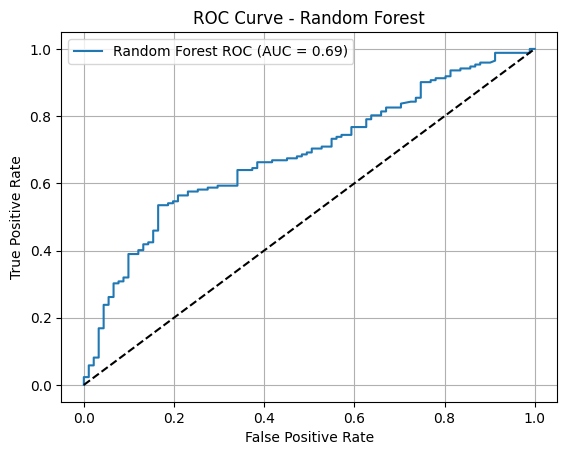

In [9]:
# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced' 
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("✅ Random Forest Accuracy: {:.2f}%".format(accuracy_rf * 100))

# Classification Report
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# Cross-validation
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print("Cross-Validation Accuracy (RF): {:.2f}%".format(rf_cv_scores.mean() * 100))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Undetected', 'Detected'],
            yticklabels=['Undetected', 'Detected'])
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
sns.barplot(x=importances[sorted_idx], y=X.columns[sorted_idx])
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# Predict probabilities for ROC
rf_prob = rf_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, rf_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'Random Forest ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid(True)
plt.show()




✅ Cross-Validation Accuracy (mean of 5 folds): 66.23%
✅ Accuracy: 65.02%

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.20      0.28        91
           1       0.68      0.89      0.77       172

    accuracy                           0.65       263
   macro avg       0.58      0.54      0.53       263
weighted avg       0.61      0.65      0.60       263



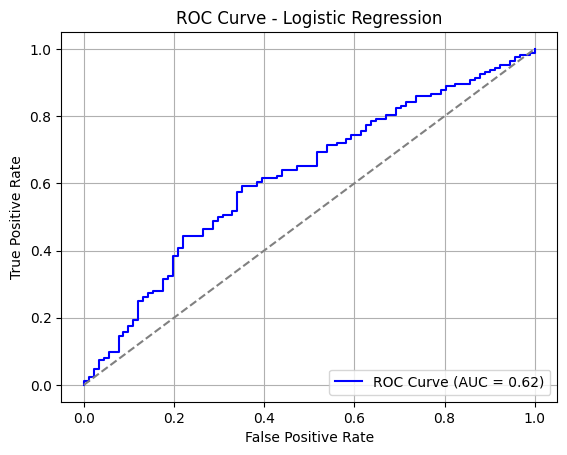

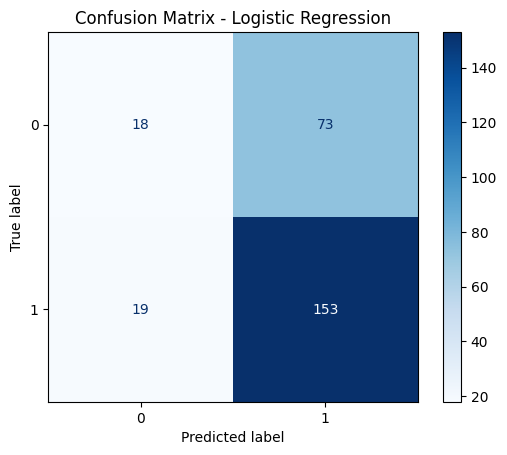

In [10]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Cross-Validation
cv_scores = cross_val_score(logreg, X_train, y_train, cv=5)
print(f"✅ Cross-Validation Accuracy (mean of 5 folds): {cv_scores.mean() * 100:.2f}%")

# Predict labels
y_pred = logreg.predict(X_test)

# Accuracy and classification report
print("✅ Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
# Predict probabilities for the positive class
y_prob = logreg.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.grid(False)
plt.show()


Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Cross-Validation Accuracy (Gradient Boosting - mean of 5 folds): 67.37%
✅ Test Accuracy (Tuned): 62.74%

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.29      0.35        91
           1       0.68      0.81      0.74       172

    accuracy                           0.63       263
   macro avg       0.56      0.55      0.54       263
weighted avg       0.60      0.63      0.60       263



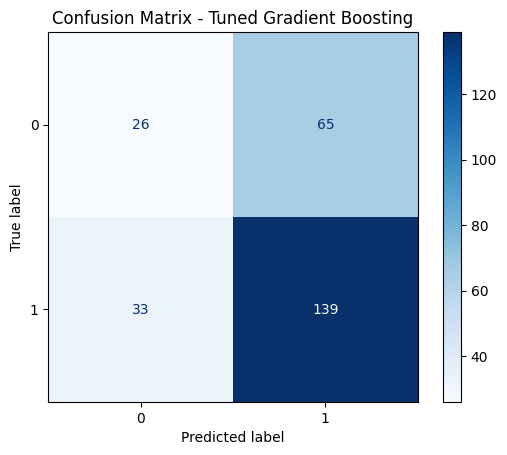

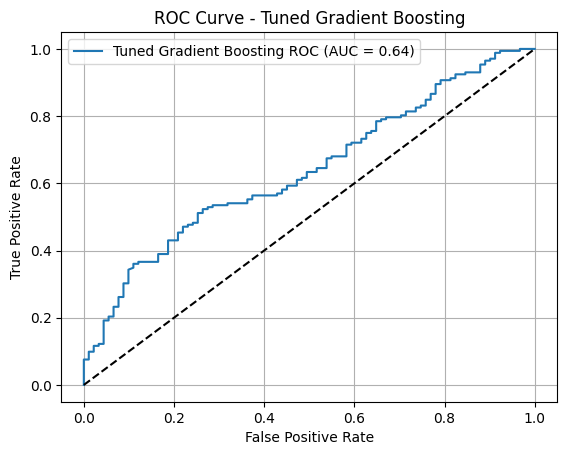

In [11]:
# Gradient Boosting
# parameter distributions
param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize base model
gb_base = GradientBoostingClassifier(random_state=42)

# Run RandomizedSearchCV
gb_random = RandomizedSearchCV(
    estimator=gb_base,
    param_distributions=param_dist,
    n_iter=20,  # Number of combinations to try
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

gb_random.fit(X_train, y_train)

# Best model
gb_model = gb_random.best_estimator_

# Cross-validation
gb_cv_scores = cross_val_score(gb_model, X_train, y_train, cv=5)
print("✅ Cross-Validation Accuracy (Gradient Boosting - mean of 5 folds): {:.2f}%".format(gb_cv_scores.mean() * 100))

# Predict
gb_pred = gb_model.predict(X_test)
gb_prob = gb_model.predict_proba(X_test)[:, 1]

# Accuracy
print("✅ Test Accuracy (Tuned): {:.2f}%".format(accuracy_score(y_test, gb_pred) * 100))
print("\nClassification Report:\n", classification_report(y_test, gb_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(gb_model, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix - Tuned Gradient Boosting')
plt.grid(False)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, gb_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'Tuned Gradient Boosting ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned Gradient Boosting')
plt.legend()
plt.grid(True)
plt.show()


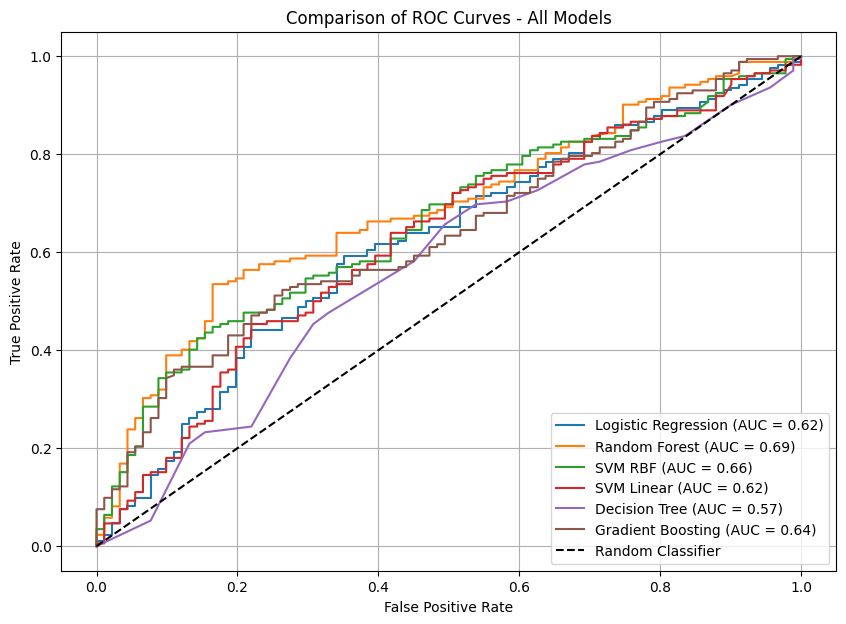

In [12]:
# Predict probabilities for ROC (positive class = 1)
logreg_prob = logreg.predict_proba(X_test)[:, 1]
rf_prob = rf_model.predict_proba(X_test)[:, 1]
svm_prob = svm.predict_proba(X_test_scaled)[:, 1]
svm_linear_prob = svm_linear.predict_proba(X_test_scaled)[:, 1]
dt_prob = dt_model.predict_proba(X_test)[:, 1]
gb_prob = gb_model.predict_proba(X_test)[:, 1]

# Compute ROC curves and AUCs
fpr_log, tpr_log, _ = roc_curve(y_test, logreg_prob)
auc_log = auc(fpr_log, tpr_log)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_prob)
auc_svm = auc(fpr_svm, tpr_svm)

fpr_svm_lin, tpr_svm_lin, _ = roc_curve(y_test, svm_linear_prob)
auc_svm_lin = auc(fpr_svm_lin, tpr_svm_lin)

fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_prob)
auc_dt = auc(fpr_dt, tpr_dt)

fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_prob)
auc_gb = auc(fpr_gb, tpr_gb)

# Plot all ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc_log:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM RBF (AUC = {auc_svm:.2f})')
plt.plot(fpr_svm_lin, tpr_svm_lin, label=f'SVM Linear (AUC = {auc_svm_lin:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {auc_gb:.2f})')

# Random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Graph labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves - All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()